<a href="https://colab.research.google.com/github/TaeGongKim/tensorflow-developer/blob/main/Sequences%2C%20Time%20Series%20and%20Prediction/Mean_Absolute_Error_for_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(False)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.1, np.cos(season_time * 6 * np.pi),
                  2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(10 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.005
noise_level = 3

In [4]:
series = baseline + trend(time, slope) + seasonality(time, period = 365,
                                                     amplitude = amplitude)
series += noise(time, noise_level, seed = 51)

In [5]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

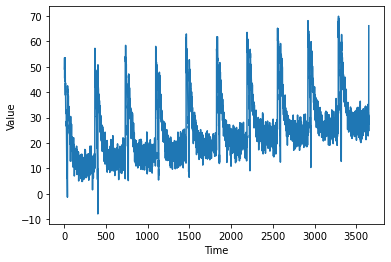

In [7]:
plot_series(time, series)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.9)

In [15]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

In [16]:
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
94/94 [==============================] - 8s 25ms/step - loss: 4.1267 - mae: 4.5956
Epoch 2/100
94/94 [==============================] - 2s 24ms/step - loss: 4.1115 - mae: 4.5806
Epoch 3/100
94/94 [==============================] - 2s 25ms/step - loss: 4.0794 - mae: 4.5474
Epoch 4/100
94/94 [==============================] - 2s 24ms/step - loss: 4.0464 - mae: 4.5134
Epoch 5/100
94/94 [==============================] - 2s 25ms/step - loss: 4.0139 - mae: 4.4797
Epoch 6/100
94/94 [==============================] - 2s 24ms/step - loss: 3.9816 - mae: 4.4466
Epoch 7/100
94/94 [==============================] - 2s 24ms/step - loss: 3.9494 - mae: 4.4142
Epoch 8/100
94/94 [==============================] - 2s 24ms/step - loss: 3.9181 - mae: 4.3833
Epoch 9/100
94/94 [==============================] - 2s 24ms/step - loss: 3.8891 - mae: 4.3548
Epoch 10/100
94/94 [==============================] - 2s 25ms/step - loss: 3.8623 - mae: 4.3279
Epoch 11/100
94/94 [=============================

(1e-08, 0.0001, 0.0, 30.0)

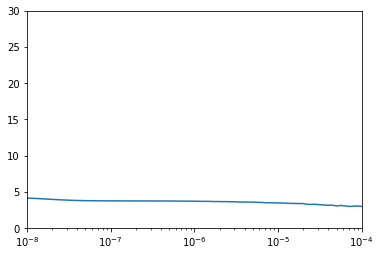

In [17]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
              metrics = ['mae'])

In [21]:
history = model.fit(dataset, epochs = 500, verbose = 1)

Epoch 1/500
94/94 [==============================] - 8s 24ms/step - loss: 124.0611 - mae: 7.8903
Epoch 2/500
94/94 [==============================] - 2s 25ms/step - loss: 58.1973 - mae: 4.9085
Epoch 3/500
94/94 [==============================] - 2s 24ms/step - loss: 38.7225 - mae: 3.9351
Epoch 4/500
94/94 [==============================] - 2s 24ms/step - loss: 31.2657 - mae: 3.5636
Epoch 5/500
94/94 [==============================] - 2s 24ms/step - loss: 27.9365 - mae: 3.3757
Epoch 6/500
94/94 [==============================] - 2s 24ms/step - loss: 26.9050 - mae: 3.3436
Epoch 7/500
94/94 [==============================] - 2s 24ms/step - loss: 26.3296 - mae: 3.3346
Epoch 8/500
94/94 [==============================] - 2s 24ms/step - loss: 25.2788 - mae: 3.2825
Epoch 9/500
94/94 [==============================] - 2s 24ms/step - loss: 25.3247 - mae: 3.3078
Epoch 10/500
94/94 [==============================] - 2s 24ms/step - loss: 24.2723 - mae: 3.2455
Epoch 11/500
94/94 [==================

In [22]:
forcast = []
for time in range(len(series) - window_size):
  forcast.append(model.predict(series[time:time + window_size][np.newaxis]))

forcast = forcast[split_time - window_size:]
results = np.array(forcast)[:, 0, 0]

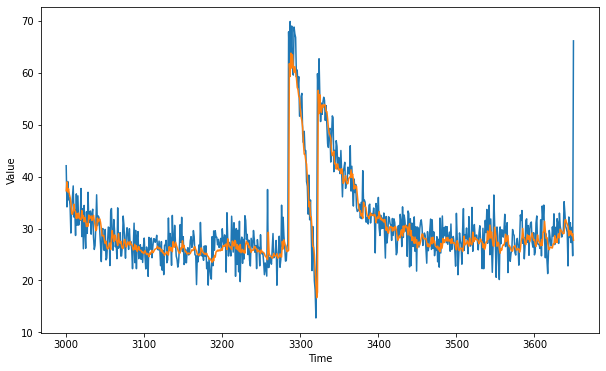

In [23]:
plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.8471289

<Figure size 432x288 with 0 Axes>

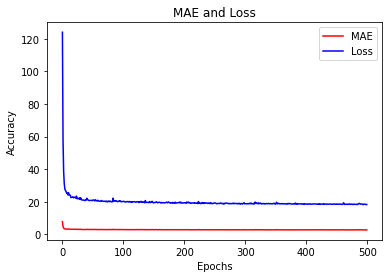

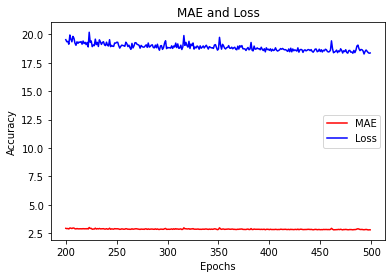

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()